# Modelo inicial (XGBoost)

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

from xgboost import XGBClassifier

## Importar Datos

In [2]:
data = pd.read_csv('../data/processed/adult.data')

In [3]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
y.dtype

dtype('int64')

### División de conjuntos de prueba y entrenamiento

In [5]:
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
sum(y_entreno == 0)

np.int64(29712)

## Entrenar el modelo

In [7]:
clasificador = XGBClassifier()
clasificador.fit(X_entreno, y_entreno)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluar el modelo

In [8]:
y_pred = clasificador.predict(X_prueba)
y_proba = clasificador.predict_proba(X_prueba)[:, 1]

In [9]:
print(classification_report(y_prueba, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8988    0.9485    0.9230      7416
           1     0.8028    0.6625    0.7260      2347

    accuracy                         0.8798      9763
   macro avg     0.8508    0.8055    0.8245      9763
weighted avg     0.8757    0.8798    0.8756      9763



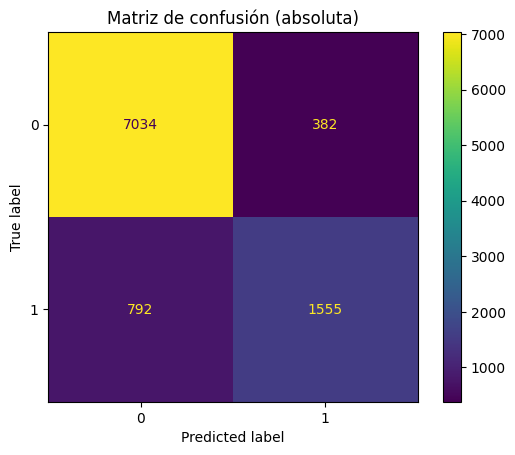

In [10]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_prueba, y_pred)).plot(ax=ax)
plt.title("Matriz de confusión (absoluta)")
plt.show()

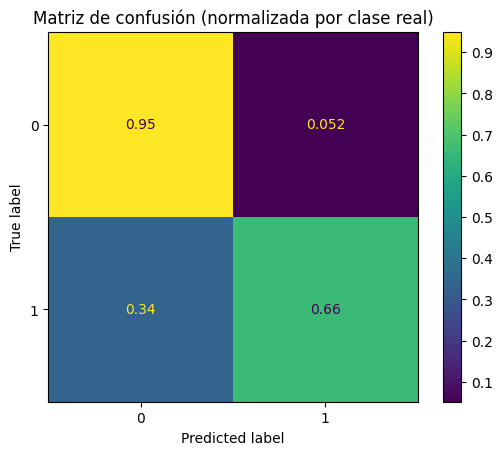

In [11]:
fig, ax = plt.subplots()
cm_norm = confusion_matrix(y_prueba, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(ax=ax)
plt.title("Matriz de confusión (normalizada por clase real)")
plt.show()